In [1]:
import pandas as pd
import numpy as np
import matplotlib
import tensorflow as tf

In [2]:
data = pd.read_csv('example_data.csv', index_col='Unnamed: 0')

In [3]:
data.iloc[0:5,0:5]

,A/G,ALB,ALP,ALT,apoA
1,1.05,29.8,209,200,0.44
2,0.99,36.6,109,113,0.96
3,2.48,47.2,54,168,0.98
4,0.77,34.7,140,27,0.70
5,1.81,46.5,58,131,1.74


In [4]:
sum_data = pd.read_csv('sum_data.csv', index_col='Unnamed: 0')

In [5]:
sum_data.iloc[0:5,:]

,mean,sd,mean-2*sd,mean+2*sd,min_fin,max_fin
A/G,1.520171,0.307871,0.904428,2.135913,0.904428,2.135913
ALB,41.243041,4.542076,32.158889,50.327192,32.158889,50.327192
ALP,81.823572,59.322209,-36.820845,200.467990,11.000000,200.467990
ALT,28.028257,53.211918,-78.395580,134.452094,2.000000,134.452094
apoA,1.288934,0.304473,0.679987,1.897881,0.679987,1.897881


In [6]:
# data.iloc[0,0:4] = "P"
# data.iloc[1,0:2] = "P"

### Detect missing values and replace (missing values <=3)

In [7]:
data.iloc[:, 0:49] = data.iloc[:, 0:49].apply(pd.to_numeric, errors='coerce')

In [8]:
data.iloc[0:5,0:7]

,A/G,ALB,ALP,ALT,apoA,apoB,AST
1,1.05,29.8,209,200,0.44,1.00,200
2,0.99,36.6,109,113,0.96,0.78,38
3,2.48,47.2,54,168,0.98,1.20,56
4,0.77,34.7,140,27,0.70,0.70,25
5,1.81,46.5,58,131,1.74,0.86,74


In [9]:
if data.isna().values.any():
# replace missing values with 0
    data.fillna(0, inplace=True)

In [10]:
data.iloc[0:5,0:7]

,A/G,ALB,ALP,ALT,apoA,apoB,AST
1,1.05,29.8,209,200,0.44,1.00,200
2,0.99,36.6,109,113,0.96,0.78,38
3,2.48,47.2,54,168,0.98,1.20,56
4,0.77,34.7,140,27,0.70,0.70,25
5,1.81,46.5,58,131,1.74,0.86,74


In [11]:
# Check for missing values

# Detect number of missing values in each row
detect_na = data.iloc[:, 0:49].apply(lambda x: np.sum(x == 0), axis=1).to_frame()
detect_na.columns = ['number of NA']

# Identify indices of rows with more than 3 missing values
ind_rm = detect_na[detect_na['number of NA'] > 3].index

# Remove rows with more than 3 missing values
data = data.drop(ind_rm)

In [12]:
for i in range(data.shape[0]):
    for j in range(49):
        if data.iloc[i, j] == 0:
            data.iloc[i, j] = sum_data.iloc[j, 0]

### Feature clipping

In [13]:
for i in range(len(data)):
    for j in range(49):
        data.iloc[i, j] = max(min(data.iloc[i, j], sum_data.iloc[j, 5]),sum_data.iloc[j, 4])

### Data normalization

In [14]:
for i in range(len(data)):
    for j in range(49):
        data.iloc[i, j] = (data.iloc[i, j]-sum_data.iloc[j, 4])/(sum_data.iloc[j, 5]-sum_data.iloc[j, 4])

### Convert data

In [15]:
data_feature = data.iloc[: , 0:49]

In [16]:
fmap_shape = (7,7)
embedding = pd.read_csv('embedding.csv', index_col='Unnamed: 0')
col_asses = embedding['indices']

In [17]:
nrow = data_feature.index.size
data_2d = []

for i in range(nrow):
    rec = np.array(data_feature.iloc[i,:])
    empty = np.zeros(fmap_shape, dtype='O').reshape(7*7,)
    empty[col_asses] = rec
    rec = empty.reshape(7,7)
    data_2d.append(rec)

data_2d = np.array(data_2d)

In [18]:
from tensorflow.keras.utils import to_categorical
num_classes = 2
label = np.array(data['dig'])
label[label == 'N'] = 0
label[label == 'P'] = 1
label = to_categorical(label, num_classes)

In [19]:
label

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

([], [])

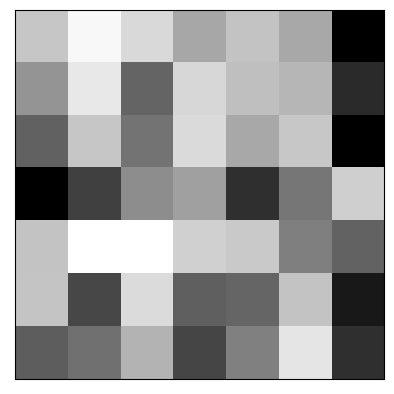

In [20]:
import matplotlib.pyplot as plt
b = np.around(data_2d[9].astype('float32'),4)
plt.imshow(b,cmap="Greys")
plt.xticks([])
plt.yticks([])

In [21]:
np.save('data.npy', data_2d)    # .npy extension is added if not given
np.save('label.npy', label)  
# d = np.load('data_intermediate/x_train.npy',allow_pickle=True)
# d[0] == x_train[0]
# # x_train == d
# d.shape